In [24]:
from pathlib import Path
import pandas as pd
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from fastcore.all import L, noop
import os
import torch
from torch import tensor, nn, optim
from torchvision.io import read_image, ImageReadMode
import numpy as np
from torch.utils.data import DataLoader

from miniai.datasets import show_image, show_images, DataLoaders, get_dls

import matplotlib as mpl

import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F

from functools import partial
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler

from miniai.augment import * #Random Erase
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.accel import *
from miniai.training import *

In [25]:
mpl.rcParams.update({'font.size': 10})
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)

In [26]:
path_data = Path('data/tiny-imagenet-200')
path_data_train = path_data/'train'
path_data_val = path_data/'val'

In [27]:
class TinyTrainDS:
    def __init__(self, path):
        self.path = path
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        return self.files[i], Path(self.files[i]).parent.parent.name

In [28]:
ds_train = TinyTrainDS(path_data_train)
len(ds_train)

100000

In [29]:
path_anno = path_data_val/'val_annotations.txt'
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())
len(anno)

10000

In [30]:
class TinyValDS(TinyTrainDS):
    def __getitem__(self, i):
        return self.files[i], anno[os.path.basename(self.files[i])]

In [31]:
ds_val = TinyValDS(path_data_val)

In [32]:
bs = 512
dlt = DataLoader(ds_train, bs, shuffle=True, num_workers=8)
xb, yb = next(iter(dlt))
xb_mean_std = [read_image(o, mode=ImageReadMode.RGB)/255 for o in xb]
xb_mean_std = torch.stack(xb_mean_std)
xb_mean_std.shape
x_mean = xb_mean_std.mean((0,2,3))
x_std  = xb_mean_std.std((0,2,3))
print(x_mean, x_std)

tensor([0.48260, 0.44914, 0.40098]) tensor([0.27336, 0.26499, 0.27673])


In [33]:
def tfrm_x(x):
    img = read_image(x, mode=ImageReadMode.RGB)/255
    img = (img - x_mean[:,None,None]) / x_std[:,None,None]
    return img

In [34]:
path_wnids = path_data/'wnids.txt'
itos = {k:v for k,v in enumerate(path_wnids.read_text().splitlines())}
stoi = {v:k for k,v in enumerate(path_wnids.read_text().splitlines())}

In [35]:
stoi

{'n02124075': 0,
 'n04067472': 1,
 'n04540053': 2,
 'n04099969': 3,
 'n07749582': 4,
 'n01641577': 5,
 'n02802426': 6,
 'n09246464': 7,
 'n07920052': 8,
 'n03970156': 9,
 'n03891332': 10,
 'n02106662': 11,
 'n03201208': 12,
 'n02279972': 13,
 'n02132136': 14,
 'n04146614': 15,
 'n07873807': 16,
 'n02364673': 17,
 'n04507155': 18,
 'n03854065': 19,
 'n03838899': 20,
 'n03733131': 21,
 'n01443537': 22,
 'n07875152': 23,
 'n03544143': 24,
 'n09428293': 25,
 'n03085013': 26,
 'n02437312': 27,
 'n07614500': 28,
 'n03804744': 29,
 'n04265275': 30,
 'n02963159': 31,
 'n02486410': 32,
 'n01944390': 33,
 'n09256479': 34,
 'n02058221': 35,
 'n04275548': 36,
 'n02321529': 37,
 'n02769748': 38,
 'n02099712': 39,
 'n07695742': 40,
 'n02056570': 41,
 'n02281406': 42,
 'n01774750': 43,
 'n02509815': 44,
 'n03983396': 45,
 'n07753592': 46,
 'n04254777': 47,
 'n02233338': 48,
 'n04008634': 49,
 'n02823428': 50,
 'n02236044': 51,
 'n03393912': 52,
 'n07583066': 53,
 'n04074963': 54,
 'n01629819': 55,
 '

In [36]:
def tfrm_y(y):
    return tensor(stoi[y])

In [37]:
class TfrmDS:
    def __init__(self, ds, tfrm_x=noop, tfrm_y=noop):
        self.ds = ds
        self.tfrm_x = tfrm_x
        self.tfrm_y = tfrm_y

    def __len__(self): return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i]
        return self.tfrm_x(x), self.tfrm_y(y) 

In [38]:
ds_trfm_train = TfrmDS(ds_train,tfrm_x, tfrm_y)
ds_trfm_val = TfrmDS(ds_val,tfrm_x, tfrm_y)

In [39]:
ds_trfm_train[0]

(tensor([[[0.32904, 0.21428, 0.12820,  ..., 0.65899, 0.87418, 0.63030],
          [0.18558, 0.14255, 0.14255,  ..., 0.58726, 0.74507, 0.58726],
          [0.11386, 0.09951, 0.11386,  ..., 0.48684, 0.54423, 0.50119],
          ...,
          [0.07082, 0.09951, 0.12820,  ..., 0.80245, 0.68768, 0.54423],
          [0.11386, 0.14255, 0.15689,  ..., 0.68768, 0.67334, 0.87418],
          [0.17124, 0.18558, 0.18558,  ..., 0.31470, 0.78810, 0.93156]],
 
         [[0.40652, 0.28813, 0.19934,  ..., 0.70250, 0.90969, 0.65810],
          [0.25853, 0.21413, 0.21413,  ..., 0.62851, 0.77650, 0.61371],
          [0.18454, 0.16974, 0.18454,  ..., 0.52491, 0.56931, 0.52491],
          ...,
          [0.08094, 0.11054, 0.16974,  ..., 0.88009, 0.79129, 0.64330],
          [0.12534, 0.15494, 0.19934,  ..., 0.77650, 0.77650, 0.98368],
          [0.15494, 0.19934, 0.22893,  ..., 0.39172, 0.89489, 1.04288]],
 
         [[0.39325, 0.27988, 0.19485,  ..., 0.61998, 0.86089, 0.61998],
          [0.25154, 0.20902,

In [40]:
path_words = path_data/'words.txt'
categories = [o.split() for o in path_words.read_text().splitlines()]
cat = dict(o[:2] for o in categories if o[0] in list(stoi.keys()))
len(cat)

200

In [41]:
def denorm(x):
    return (x*x_std[:,None,None]+x_mean[:,None,None]).clip(0,1)

In [42]:
bs = 512
dlt = DataLoader(ds_trfm_train, bs, shuffle=True, num_workers=8)
xb, yb = next(iter(dlt))

<Axes: >

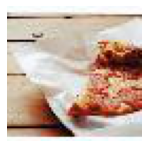

In [43]:
show_image(denorm(xb[0]), figsize=(2.5,2.5))

In [44]:
titles = [cat[itos[o]] for o in yb[:9].tolist()]

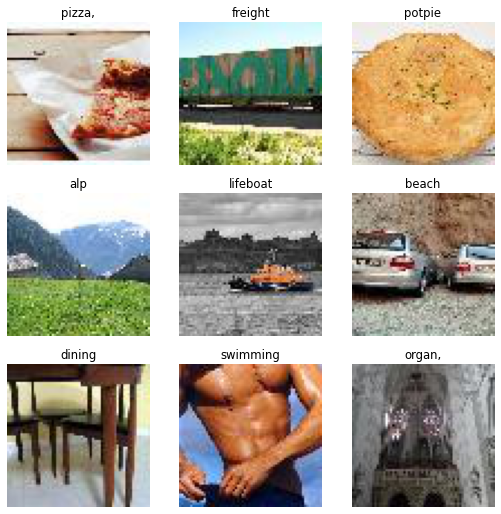

In [45]:
show_images(denorm(xb[:9]), titles=titles)

In [46]:
dls = DataLoaders(*get_dls(ds_trfm_train,ds_trfm_val,bs=bs, num_workers=8))

In [ ]:
def tfm_batch(b, tfmx):


In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])